In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib 

In [13]:
primary_date = datetime.date(2020, 7, 13)
if (datetime.date.today() > primary_date):
    print("It's already after the primary. Why are you running this?")
    
# import data
df_raw = pd.read_excel("Roster.xlsx")
df = df_raw.copy()
df = df[df.Drafter.notnull()]
df["Points Contributed"] = 0.
df["Value"] = 0.


In [14]:
# Calculate date range
start_date = datetime.date(2019, 6, 15)
today_date = datetime.date.today();
day_delta = (today_date - start_date).days
print("{0} days have elapsed since the start of the draft (June 15, 2019)".format(day_delta))

primary_delta = (primary_date - datetime.date.today()).days
print("{0} days until the start of the Democratic Convention (July 13, 2020)".format(primary_delta))


220 days have elapsed since the start of the draft (June 15, 2019)
174 days until the start of the Democratic Convention (July 13, 2020)


In [15]:
# Calculate point totals
# Total number of points on a per day basis for a candidate that has not dropped
ideal_points = np.array(range(day_delta))+1
drafter_points = {} # dictionary to hold point totals

for (candidate, drafter) in zip(df.index, df["Drafter"]):
    drop_date = df.at[candidate,"Date Dropped"]
    if(drop_date=="-"):
        drafter_points[drafter] = drafter_points.get(drafter, np.zeros(day_delta)) + ideal_points
        df.at[candidate,"Points Contributed"] = day_delta
        df.at[candidate,"Value"] = day_delta / df.at[candidate,"Final Bid"] if df.at[candidate,"Final Bid"] > 0 else 0.
    else:
        time_in_race = (drop_date.date() - start_date).days
        df.at[candidate,"Points Contributed"] = time_in_race
        df.at[candidate,"Value"] = time_in_race/df.at[candidate,"Final Bid"] if df.at[candidate,"Final Bid"] > 0 else 0.
        temp_points = ideal_points.copy()
        temp_points[-1:time_in_race-1:-1] = time_in_race
        drafter_points[drafter] = drafter_points.get(drafter, np.zeros(day_delta)) + temp_points

# Sort in total accumulated point order
drafter_points = {k: v for k, v in sorted(drafter_points.items(), key=lambda e: e[1][-1], reverse=True)}
for drafter in drafter_points:
    print("{0} has {1} points".format(drafter, int(drafter_points[drafter][-1])))

Daniel has 738 points
Michael has 684 points
Sara has 661 points
Kevin M has 534 points
Jeff has 509 points
Kevin K has 507 points


In [16]:
# Setup for plots
drafters = sorted(df.Drafter.unique())
c = [plt.cm.tab10(i) for i in range(len(drafters))]
colors = dict(zip(drafters,c))
dates = [start_date + datetime.timedelta(days=i) for i in range(day_delta)]
alpha_val = 1.0;

/Users/danielrevier/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


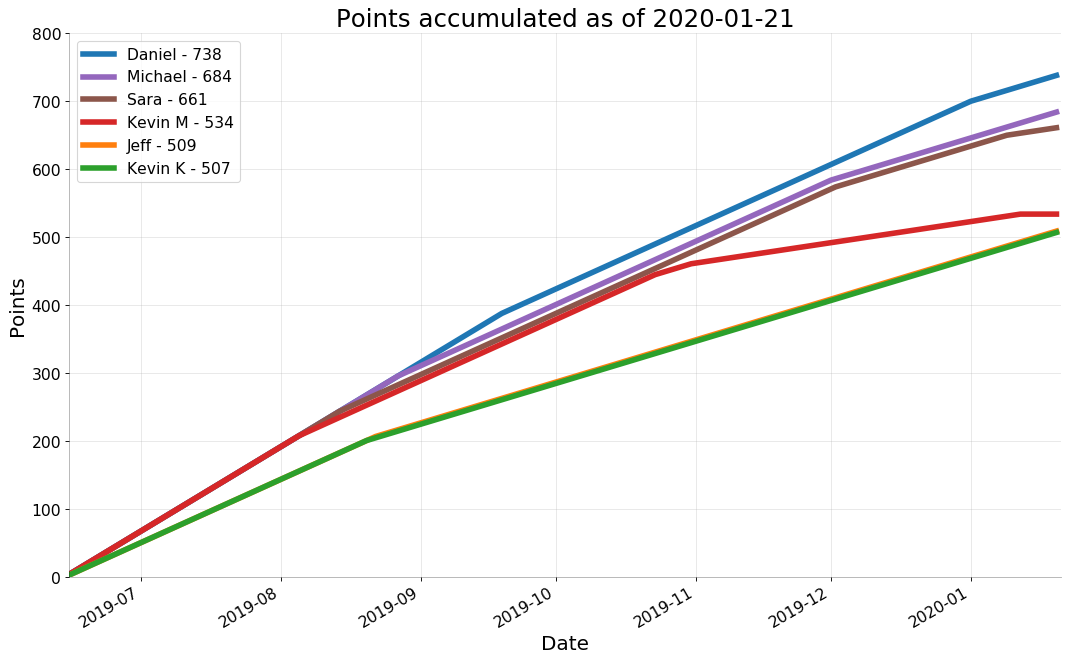

In [17]:
# Draw plot
fig1, ax1 = plt.subplots(figsize=(16,10),facecolor='white',dpi=80)
for i,drafter in enumerate(drafter_points):
    ax1.plot(dates, drafter_points[drafter],c=colors[drafter],alpha=alpha_val,linewidth=5);

# Title, Label, Ticks, Lims and Legend
fig1.autofmt_xdate();
ax1.set_title("Points accumulated as of {}".format(datetime.date.today()),fontdict={'size':22})
ax1.set(xlim=(start_date,today_date),ylim=(0,800))
ax1.set_xlabel("Date",fontsize=18);
ax1.set_ylabel("Points",fontsize=18);
plt.yticks(fontsize=14); plt.xticks(fontsize=14);
plt.grid(axis="both", alpha=.3)
leg = [i+' - '+str(j) for i,j in zip(list(drafter_points.keys()),[int(drafter_points[x][-1]) for x in drafter_points])]
plt.legend(leg,fontsize=14);


# Remove borders
ax1.spines["top"].set_alpha(0.0)
ax1.spines["bottom"].set_alpha(0.3)
ax1.spines["right"].set_alpha(0.0)
ax1.spines["left"].set_alpha(0.3)

# Save fig
# plt.savefig("figs/point_total_{}.png".format(datetime.date.today()));
plt.savefig("figs/point_total.png");

In [18]:
# Sorted by value
df.sort_values(by=['Drafter','Value'],inplace=True)
df.reset_index(inplace=True,drop=True)
df.head()

,Candidate,Draft Order,Bidder,Drafter,Initial Bid,Final Bid,Date Dropped,Points Contributed,Value
0,Blasio,11.0,Daniel,Daniel,60.0,60.0,2019-09-20 00:00:00,97.0,1.616667
1,Yang,6.0,Kevin K,Daniel,10.0,59.0,-,220.0,3.728814
2,Gabbard,16.0,Sara,Daniel,5.0,51.0,-,220.0,4.313725
3,Castro,10.0,Sara,Daniel,15.0,30.0,2020-01-02 00:00:00,201.0,6.700000
4,Sanders,4.0,Sara,Jeff,30.0,135.0,-,220.0,1.629630


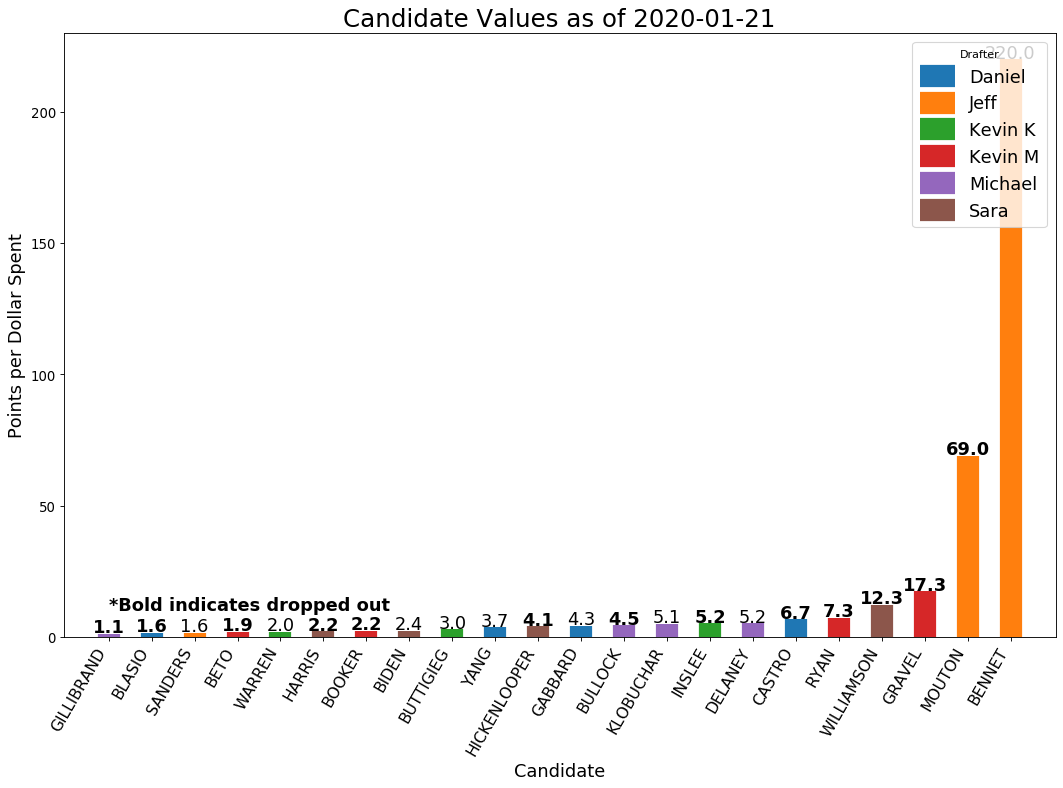

In [25]:
# Draw plot
fig, ax = plt.subplots(figsize=(16,10),facecolor='white',dpi=80)
for drafter in drafters:
    tmp = df[df["Drafter"].eq(drafter)]
    ax.vlines(x=tmp.index, ymin=0, ymax=tmp.Value,color=colors[drafter],alpha=alpha_val,linewidth=20)
    # Annotation text
    for index,row in tmp.iterrows():
        fw = 'normal' if row["Date Dropped"]=='-' else 'bold'
        ax.text(index,row.Value+0.5,round(row.Value,1),horizontalalignment='center',fontsize=16,fontweight=fw)


ax.text(0, 10, "*Bold indicates dropped out",fontweight='bold',fontsize=16)

# Title, Label, Ticks and Ylim
ax.set_title("Candidate Values as of {}".format(datetime.date.today()),fontdict={'size':22})
ax.set(ylim=(0,10+max(df.Value)))
ax.set_ylabel("Points per Dollar Spent",fontsize=16)
ax.set_xlabel("Candidate",fontsize=16)
plt.xticks(df.index, df.Candidate.str.upper(),rotation=60,horizontalalignment='right',fontsize=14)
plt.yticks(fontsize=12);
plt.legend(drafters,title="Drafter",fontsize=16);

# Save fig
plt.savefig("figs/candidate_values_{}.png".format(datetime.date.today()))
plt.savefig("figs/candidate_values.png")

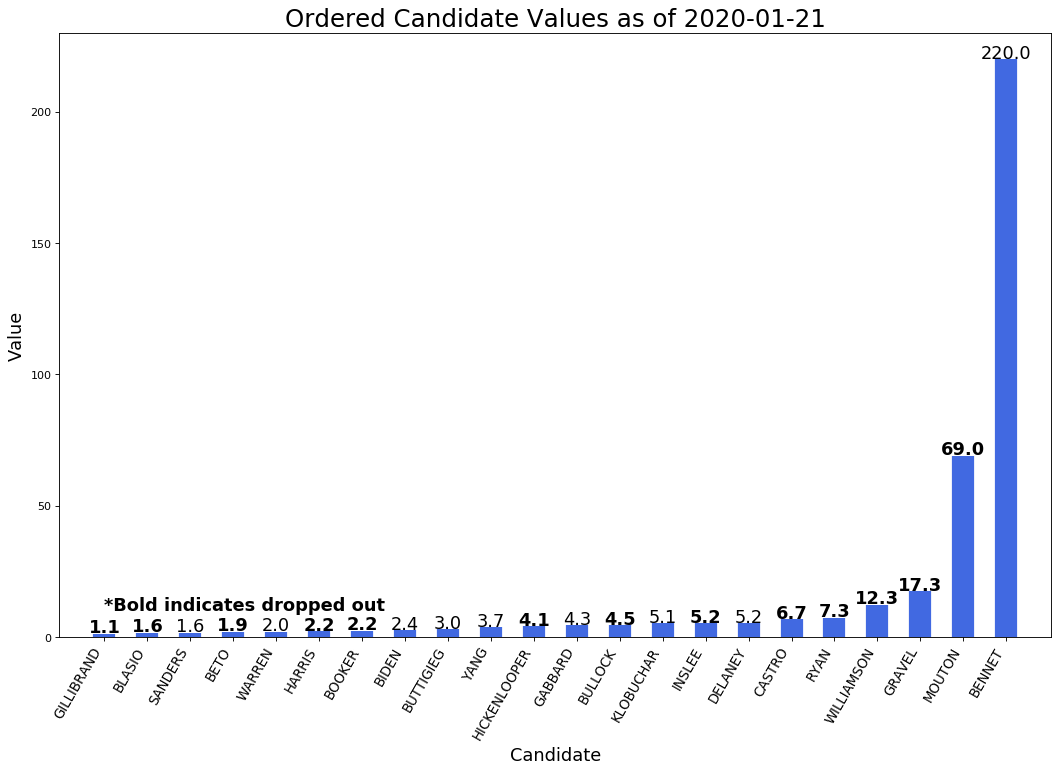

In [24]:
# Sorted value bar chart
df.sort_values(by=['Value','Candidate'],inplace=True)
df.reset_index(inplace=True,drop=True)

fig, ax = plt.subplots(figsize=(16,10),facecolor="white",dpi=80);
ax.vlines(x=df.index,ymin=0,ymax=df.Value,color='royalblue',alpha=alpha_val,linewidth=20)

# Annotate
for index,row in df.iterrows():
    fw = 'normal' if row["Date Dropped"]=='-' else 'bold'
    ax.text(index,row.Value+0.5,round(row.Value,1),horizontalalignment='center',fontsize=16,fontweight=fw)

ax.text(0, 10, "*Bold indicates dropped out",fontweight='bold',fontsize=16)

# Title, Label, Ticks and YLim
ax.set_title('Ordered Candidate Values as of {}'.format(datetime.date.today()),fontdict={'size':22})
ax.set(ylim=(0,10+max(df.Value)));
ax.set_ylabel("Value",fontsize=16);
ax.set_xlabel("Candidate",fontsize=16)

plt.xticks(df.index, df.Candidate.str.upper(), rotation=60,horizontalalignment='right',fontsize=12);

# Save fig
# plt.savefig("figs/candidate_values_ordered_{}.png".format(datetime.date.today()))
plt.savefig("figs/candidate_values_ordered.png")

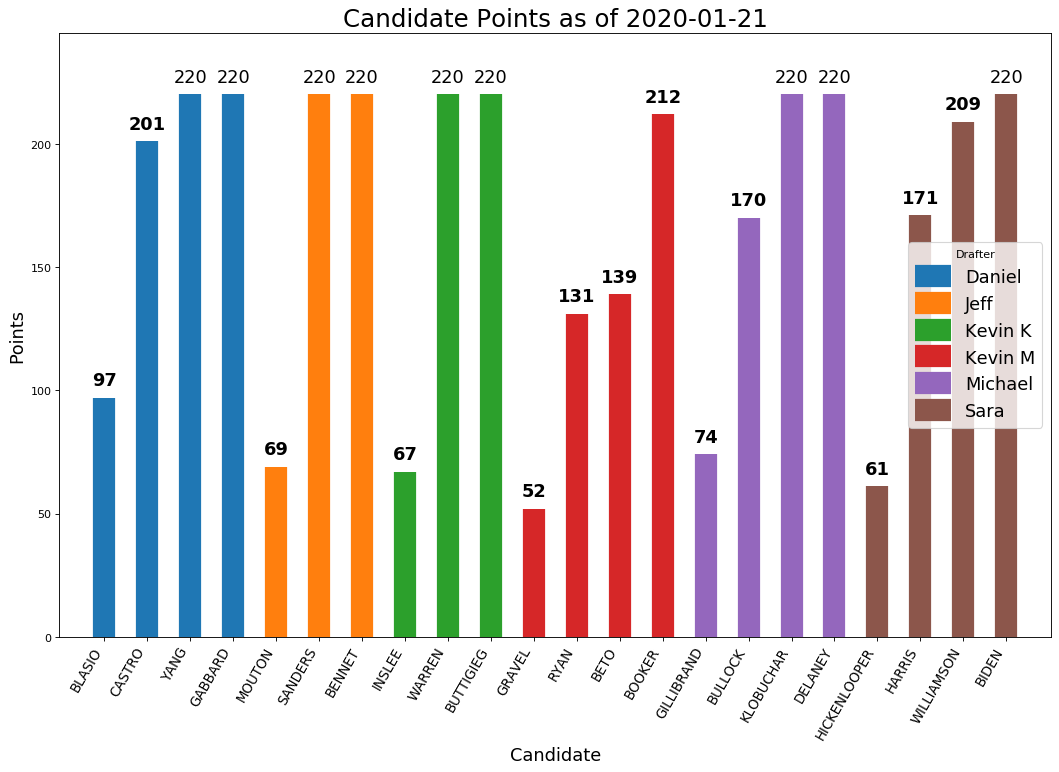

In [21]:
# Sorted point contribution bar chart
df.sort_values(by=['Drafter','Points Contributed'],inplace=True)
df.reset_index(inplace=True,drop=True)

fig, ax = plt.subplots(figsize=(16,10),facecolor="white",dpi=80);
for drafter in drafters:
    tmp = df[df["Drafter"].eq(drafter)]
    ax.vlines(x=tmp.index, ymin=0, ymax=tmp["Points Contributed"],color=colors[drafter],alpha=alpha_val,linewidth=20)
    # Annotation text
    for index,row in tmp.iterrows():
        fw = 'normal' if row["Date Dropped"]=='-' else 'bold'
        ax.text(index,row["Points Contributed"]+5,int(row["Points Contributed"]),horizontalalignment='center',fontsize=16,fontweight=fw)

# Title, Label, Ticks and YLim
ax.set_title('Candidate Points as of {}'.format(datetime.date.today()),fontdict={'size':22})
ax.set(ylim=(0,25+max(df["Points Contributed"])))
ax.set_ylabel("Points",fontsize=16);
ax.set_xlabel("Candidate",fontsize=16)
plt.xticks(df.index, df.Candidate.str.upper(), rotation=60,horizontalalignment='right',fontsize=12);
plt.legend(drafters,title="Drafter",fontsize=16,loc='center right');

# Save fig
# plt.savefig("figs/candidate_points_{}.png".format(datetime.date.today()))
plt.savefig("figs/candidate_points.png")


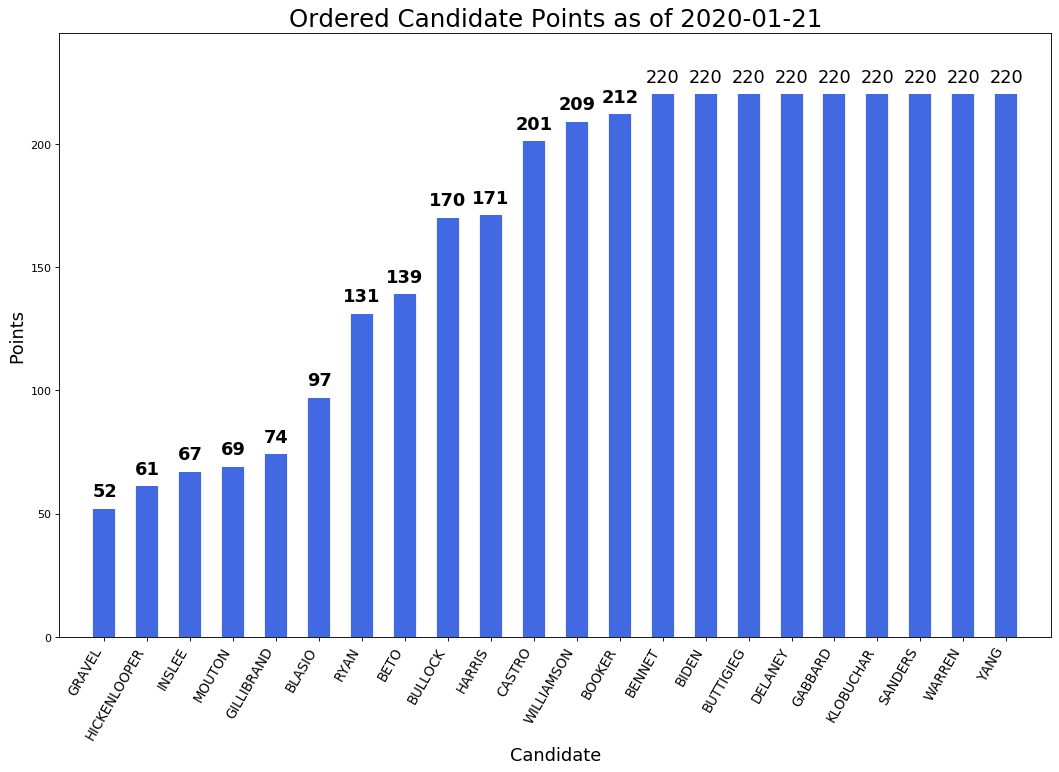

In [22]:
df.sort_values(by=['Points Contributed','Candidate'],inplace=True)
df.reset_index(drop=True,inplace=True)

fig, ax = plt.subplots(figsize=(16,10),facecolor="white",dpi=80);
ax.vlines(x=df.index,ymin=0,ymax=df["Points Contributed"],color='royalblue',alpha=alpha_val,linewidth=20)

# Annotation
for index,row in df.iterrows():
    fw = 'normal' if row["Date Dropped"]=='-' else 'bold'
    ax.text(index,row["Points Contributed"]+5,int(row["Points Contributed"]),horizontalalignment='center',fontsize=16,fontweight=fw)

# Title, etc
ax.set_title('Ordered Candidate Points as of {}'.format(datetime.date.today()),fontdict={'size':22})
ax.set(ylim=(0,25+max(df["Points Contributed"])))
ax.set_ylabel("Points",fontsize=16);
ax.set_xlabel("Candidate",fontsize=16)
plt.xticks(df.index, df.Candidate.str.upper(), rotation=60,horizontalalignment='right',fontsize=12);

# Save fig
# plt.savefig("figs/candidate_points_ordered_{}.png".format(datetime.date.today()))
plt.savefig("figs/candidate_points_ordered.png")